In [297]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Dropout,ReLU
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix

In [298]:
df = pd.read_csv('Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,label,unexplained_infertility,previous_miscarriages
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,1,0,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,1,0
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,1,0,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,1,0


In [299]:
tabular_data = df.drop(['id' , 'label'] , axis=1)
labels = df['label']

In [300]:
Scaler = StandardScaler()
Scaled_tabular_data = Scaler.fit_transform(tabular_data)

In [301]:
image_folder = r"C:\Users\User\Desktop\Junior\Machine\Machine Project\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"
image_list = []

for image_id in df['id']:
    img_name = f"{int(image_id):04d}.jpg"
    

    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Image not found: {img_path}")
        continue

    img = img/255.0

    img= img[..., np.newaxis]
    image_list.append(img)

x_img = np.array(image_list, dtype=np.float32)
print(f"Image data shape: {x_img.shape}")


Image data shape: (128, 256, 256, 1)


In [302]:
image_input = Input(shape=(256, 256, 1))

x = RandomFlip("horizontal")(image_input)
x = RandomRotation(0.1)(x)
x = RandomZoom(0.1)(x)

x = Conv2D(16, (3,3), kernel_regularizer=l2(1e-3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((3,3))(x)

x = Conv2D(32, (3,3), kernel_regularizer=l2(1e-3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((3,3))(x)


x = Conv2D(64, (3,3), kernel_regularizer=l2(1e-3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)


x = GlobalAveragePooling2D()(x)

x = Dense(32 , kernel_regularizer=l2(1e-3), activation='relu' , name="cnn_features")(x)
x = Dropout(0.2)(x)

cnn_feature_extractor = Model(inputs=image_input, outputs=x)
cnn_feature_extractor.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_20 (RandomFlip)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_20              │ (None, 256, 256, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_20 (RandomZoom)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 256, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_60 (ReLU)                 │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 85, 85, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 85, 85, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 85, 85, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_61 (ReLU)                 │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_62 (ReLU)                 │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_features (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,824 (100.88 KB)

 Trainable params: 25,600 (100.00 KB)

 Non-trainable params: 224 (896.00 B)

In [303]:
# Extract features for all images
cnn_features = cnn_feature_extractor.predict(x_img) 
print(f"CNN features shape: {cnn_features.shape}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
CNN features shape: (128, 32)


In [304]:
X_combined = np.concatenate([Scaled_tabular_data, cnn_features], axis=1)
print(f"Combined features shape: {X_combined.shape}") 


Combined features shape: (128, 432)


In [305]:


X_tab_trainval, X_tab_test, X_img_trainval, X_img_test, y_trainval, y_test = train_test_split(
    Scaled_tabular_data, x_img, labels, test_size=0.3, stratify=labels, random_state=42
)

X_tab_train, X_tab_val, X_img_train, X_img_val, y_train, y_val = train_test_split(
    X_tab_trainval, X_img_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
)

print("Training set:", X_tab_train.shape, X_img_train.shape)
print("Validation set:", X_tab_val.shape, X_img_val.shape)
print("Testing set:", X_tab_test.shape, X_img_test.shape)

Training set: (71, 400) (71, 256, 256, 1)
Validation set: (18, 400) (18, 256, 256, 1)
Testing set: (39, 400) (39, 256, 256, 1)


In [306]:
train_cnn_features = cnn_feature_extractor.predict(X_img_train)
val_cnn_features   = cnn_feature_extractor.predict(X_img_val)
test_cnn_features  = cnn_feature_extractor.predict(X_img_test)
print("Train CNN features:", train_cnn_features.shape)
print("Val CNN features:", val_cnn_features.shape)
print("Test CNN features:", test_cnn_features.shape)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Train CNN features: (71, 32)
Val CNN features: (18, 32)
Test CNN features: (39, 32)


In [307]:
import numpy as np

X_train_comb = np.concatenate([X_tab_train, train_cnn_features], axis=1)
X_val_comb   = np.concatenate([X_tab_val, val_cnn_features], axis=1)
X_test_comb  = np.concatenate([X_tab_test, test_cnn_features], axis=1)

print("Combined training features:", X_train_comb.shape)
print("Combined validation features:", X_val_comb.shape)
print("Combined testing features:", X_test_comb.shape)


Combined training features: (71, 432)
Combined validation features: (18, 432)
Combined testing features: (39, 432)


In [308]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_comb)
X_val_scaled   = scaler.transform(X_val_comb)
X_test_scaled  = scaler.transform(X_test_comb)


In [309]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


svm = SVC(kernel='rbf', C=1, gamma=0.001)
svm.fit(X_train_scaled, y_train)


train_acc = accuracy_score(y_train, svm.predict(X_train_scaled))
val_acc   = accuracy_score(y_val, svm.predict(X_val_scaled))
test_acc  = accuracy_score(y_test, svm.predict(X_test_scaled))

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")
print(f"Testing Accuracy: {test_acc:.3f}")


Training Accuracy: 0.775
Validation Accuracy: 0.778
Testing Accuracy: 0.718


Training ROC-AUC   : 0.913
Validation ROC-AUC : 0.600
Testing ROC-AUC    : 0.847


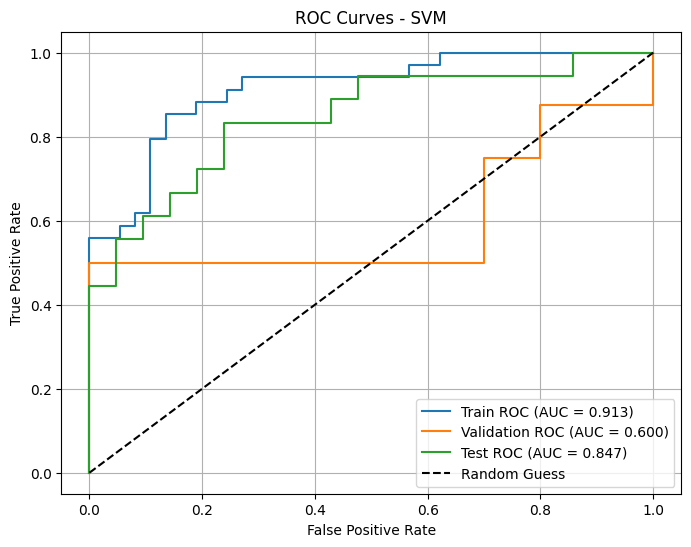

In [310]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


train_scores = svm.decision_function(X_train_scaled)
val_scores   = svm.decision_function(X_val_scaled)
test_scores  = svm.decision_function(X_test_scaled)


fpr_train, tpr_train, _ = roc_curve(y_train, train_scores)
fpr_val, tpr_val, _     = roc_curve(y_val, val_scores)
fpr_test, tpr_test, _   = roc_curve(y_test, test_scores)


auc_train = auc(fpr_train, tpr_train)
auc_val   = auc(fpr_val, tpr_val)
auc_test  = auc(fpr_test, tpr_test)


print(f"Training ROC-AUC   : {auc_train:.3f}")
print(f"Validation ROC-AUC : {auc_val:.3f}")
print(f"Testing ROC-AUC    : {auc_test:.3f}")


plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.3f})")
plt.plot(fpr_val, tpr_val, label=f"Validation ROC (AUC = {auc_val:.3f})")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.3f})")
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - SVM")
plt.legend()
plt.grid(True)
plt.show()


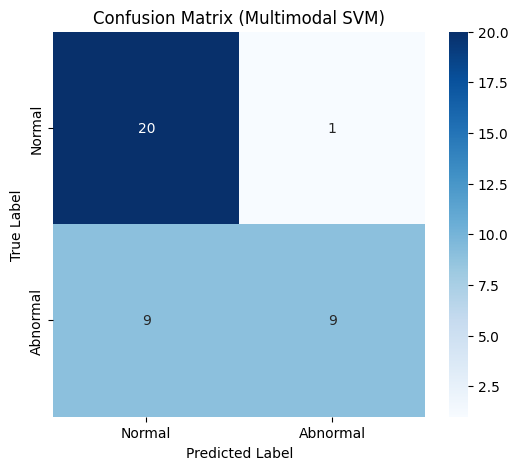

In [281]:
import seaborn as sns

y_pred = svm.predict(X_test_scaled)  


cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Abnormal"],
    yticklabels=["Normal", "Abnormal"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Multimodal SVM)")
plt.show()


In [282]:
from sklearn.metrics import classification_report


# Print classification report
print(classification_report(
    y_test, 
    y_pred, 
    labels=[0,1],                
    target_names=['normal', 'abnormal']
))


              precision    recall  f1-score   support

      normal       0.69      0.95      0.80        21
    abnormal       0.90      0.50      0.64        18

    accuracy                           0.74        39
   macro avg       0.79      0.73      0.72        39
weighted avg       0.79      0.74      0.73        39

